In [30]:
projectdir = "C:/Users/ArmanAngaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia/"
cd(projectdir)
using Pkg; Pkg.activate(projectdir)

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, LsqFit, Pipe, ProgressMeter, StatsPlots, Distributed, Roots, LinearAlgebra, BSON, Random
pyplot()

try 
    Turnover
catch e
    include(projectdir*"Turnover/src/Turnover.jl")
    include(projectdir*"Turnover/src/test.jl")
    using .Turnover
end
try SeqDataFormatting
catch e
    include(projectdir*"experimental_data/SeqDataFormatting.jl")
    import .SeqDataFormatting
end

import TumorGrowth
include(projectdir*"distribution_functions.jl")
include(projectdir*"simulated_tumors/path_format.jl")
include(projectdir*"Turnover/src/utility.jl")
include(projectdir*"sampling_analysis/plot_funcs.jl")
include("sampling_analysis/lichee_cloneclustering.jl")

plot(size=(1,1))

  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`


In [4]:
rmprocs(workers())
addprocs(4)
@everywhere using Pkg
@everywhere Pkg.activate(pwd())
@everywhere import TumorGrowth

  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`


      From worker 12:	  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`
      From worker 13:	  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`
      From worker 10:	  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`
      From worker 11:	  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`


# Load data

In [5]:
tumorinfo = dir_info_mutations(projectdir*"/simulated_tumors/3d_poisson/bulk")
filter!(r->r.N==40_000 && r.ρ == Inf && r.d in 0.0:0.2:0.8 && r.μ == 0.3 && r.dim==3, tumorinfo)
for x in groupby(tumorinfo, :d)
    print("d=",first(x.d), ": ", nrow(x), ", ")
end

d=0.0: 40, d=0.2: 40, d=0.4: 40, d=0.6: 40, d=0.8: 40, 

In [6]:
tumorinfo.tumor = @showprogress pmap(TumorGrowth.data_import, tumorinfo.tumorpath)
tumorinfo.mutations = @showprogress pmap(TumorGrowth.data_import, tumorinfo.mutationspath)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:16:20
Progress: 100%|█████████████████████████████████████████| Time: 0:03:24


In [7]:
mu = unique(tumorinfo.μ)[1]

0.3

# Sampling in plane

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


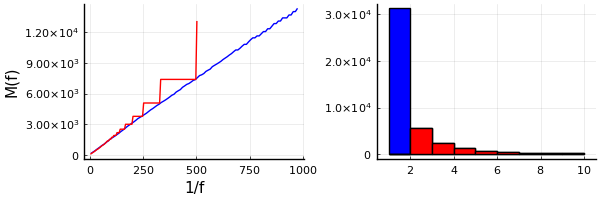

In [24]:
f_whole = Float64[]
f_sample = Float64[]
counts_all = Int[]
counts_pass = Int[]
@showprogress for row in eachrow(tumorinfo)
    t = row.tumor
    append!(f_whole, TumorGrowth.mutation_freqs(t).frequency)
    tumorsample = t[sample(1:nrow(t), 1000, replace=false), :]
    seq = TumorGrowth.mutation_freqs(tumorsample)
    append!(f_sample, seq.frequency)
    append!(counts_all, seq.reads)
    append!(counts_pass, seq.reads[seq.frequency .> 1/1000])
end
let res = 1/1000
    p = plot(layout=(1,2), size=(600,200), legend=:none)
    M!(p[1], f_whole, res=res, c=:blue)
    M!(p[1], f_sample, c=:red, res=res)
    histogram!(p[2], counts_all, bins=1:10, c=:blue)
    histogram!(p[2], counts_pass, bins=1:10, c=:red)
end

In [99]:
f_min, samplecutoff= 1/100, 1/5
samplingparams = (n = 280, cells_per_sample = 5)

tumor = rand( tumorinfo.tumor );
plane = TumorGrowth.cross_section(tumor; x=mean(tumor.position)[1], width=3, reduce_dim=true )
_, tumorsample = TumorGrowth.multi_region_sequencing(plane; samplingparams...);

┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth C:\Users\arman\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115


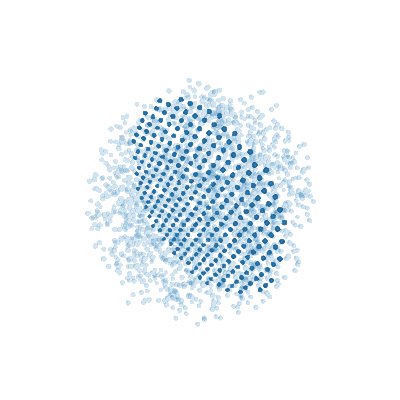

In [102]:
let t = deepcopy( tumorsample )
    x = mean(tumor.position)[1]
    for p in t.position
       pushfirst!( p, x)
    end
    sc = TumorGrowth.plotting_colored_mutations(t; size=(400,400), shading=true)
    TumorGrowth.plotting_colored_mutations!(sc, tumor[sample(1:nrow(tumor), 2000, replace=false),:]; 
            alpha=0.2, show_warning=false)
end

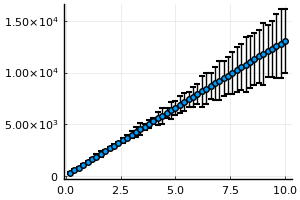

In [54]:
widths = 0.2:0.2:10.
planesizes = @showprogress map(widths) do width
    map( eachrow(tumorinfo) ) do row
        t = row.tumor
        seq_whole = TumorGrowth.mutation_freqs(t)
        append!(f_whole, seq_whole.frequency)
        plane = TumorGrowth.cross_section(tumor; x=mean(t.position)[1], width=width, reduce_dim=true )
        nrow(plane)
    end
end
scatter(widths, median.(planesizes), yerror=var.(planesizes), size=(300,200), lab="")

# Methods

In [58]:
samplecutoff= 1/3
samplingparams = (n = 275, cells_per_sample = 5)

sampling_method = tumor_3d -> begin
    
    x, cm = mean(tumor_3d.position)
    tumor = TumorGrowth.cross_section(tumor_3d; x=x, width=2.5, reduce_dim=true)
    
    _, wes_sample = TumorGrowth.multi_region_sequencing(tumor; 
        n = 30, cells_per_sample = samplingparams.cells_per_sample,
        stochastic = false, readdepth = 20)

    mutations_wes = TumorGrowth.sampletumor_mfreqs(wes_sample)
    # filter!(m->m.frequency>1/40, mutations_wes)

    samples, sanger_sample = TumorGrowth.multi_region_sequencing(tumor; 
        n = samplingparams.n, cells_per_sample = samplingparams.cells_per_sample,
        stochastic = false, readdepth = 10)

    for row in eachrow(sanger_sample)
        mask = [ m in mutations_wes.mutation && f > samplecutoff for (m,f) in zip(row.mutations, row.frequencies) ]
        row.mutations = row.mutations[mask]
        row.frequencies = row.frequencies[mask]
    end
    wes_sample, sanger_sample, samples
end

#444 (generic function with 1 method)

# Get turnover

In [84]:
Random.seed!(2000)
let 
    tumorinfo.wes_sample = Vector{DataFrame}(undef, nrow(tumorinfo))
    tumorinfo.samplingtumor = Vector{DataFrame}(undef, nrow(tumorinfo))
    tumorinfo.clonetumor_coinc = Vector{DataFrame}(undef, nrow(tumorinfo))
    tumorinfo.clonetumor_true = Vector{DataFrame}(undef, nrow(tumorinfo))
    
    @showprogress for (i,r) in enumerate(eachrow(tumorinfo))
        wes_sample, samplingtumor, samples =  r.tumor |> sampling_method
        sequencing = TumorGrowth.mutation_freqs(samplingtumor)
        r.mutations.frequency = zeros(nrow(r.mutations))
        r.mutations.frequency[sequencing.mutation]  =  sequencing.reads
        
        r.wes_sample = wes_sample
        r.samplingtumor = samplingtumor
        r.clonetumor_coinc = coincidence_clustering_clonetumor(samplingtumor)

        r.clonetumor_true = DataFrame(mutations=union(getproperty.(samples,:mutations)...))
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


In [41]:
# samplecutoff= 1/3
# samplingparams = (n = 285, cells_per_sample = 5)

# Random.seed!(1110)
# wes_n = Int[]
# let
#     tumorinfo.samples = similar(tumorinfo.tumor)
#     tumorinfo.Nthresh = similar(tumorinfo.d)
#     @showprogress for row in eachrow( tumorinfo )
        
#         tumor_3d, mutations = deepcopy( row.tumor ), row.mutations
#         x, cm = mean(tumor_3d.position)
#         tumor = TumorGrowth.cross_section(tumor_3d; x=x, width=2., reduce_dim=true)
        
#         _, wes_sample = TumorGrowth.multi_region_sequencing(tumor; 
#             n = 120, cells_per_sample = samplingparams.cells_per_sample,
#             stochastic = false, readdepth = 10)
        
#         push!(wes_n, nrow(wes_sample))

#         mutations_wes = union(wes_sample.mutations...)
        
#         # row.Nthresh = estim_N(wes_sample)
        
#         _, sanger_sample = TumorGrowth.multi_region_sequencing(tumor; 
#             n = samplingparams.n, cells_per_sample = samplingparams.cells_per_sample,
#             stochastic = false, readdepth = 10)
        
#         for row in eachrow(sanger_sample)
#             mask = [ m in mutations_wes && f > samplecutoff for (m,f) in zip(row.mutations, row.frequencies) ]
#             row.mutations = row.mutations[mask]
#             row.frequencies = row.frequencies[mask]
#         end
#         row.samples = sanger_sample
        
#         row.Nthresh = estim_N(sanger_sample)

#         tumor_freqs = TumorGrowth.mutation_freqs(tumor)
#         # samples_freqs = TumorGrowth.sampletumor_mfreqs(wes_sample)
#         samples_freqs = TumorGrowth.mutation_freqs(sanger_sample)
        
#         mutations.tumor_freq = zeros(nrow(mutations))
#         mutations.tumor_freq[tumor_freqs.mutation] = tumor_freqs.frequency
#         mutations.samples_freq = zeros(nrow(mutations))
#         mutations.samples_freq[samples_freqs.mutation] = samples_freqs.reads

#     end
# end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


In [5]:
# Random.seed!(1110)
# let
#     tumorinfo.samples = similar(tumorinfo.tumor)
#     tumorinfo.Nthresh = similar(tumorinfo.d)
#     @showprogress for row in eachrow( tumorinfo )
        
#         tumor_3d, mutations = deepcopy( row.tumor ), row.mutations
#         x, cm = mean(tumor_3d.position)
#         tumor = TumorGrowth.cross_section(tumor_3d; x=x, width=3, reduce_dim=true)
        
#         _, tumorsample = TumorGrowth.multi_region_sequencing(tumor; 
#             n = samplingparams.n, cells_per_sample = samplingparams.cells_per_sample,
#             stochastic = false, readdepth = 40)
#         for row in eachrow(tumorsample)
#             row.mutations = row.mutations[row.frequencies .> samplecutoff]
#             row.frequencies = row.frequencies[row.frequencies .> samplecutoff]
#         end
#         row.samples = tumorsample
        
#         row.Nthresh = estim_N(tumorsample)

#         tumor_freqs = TumorGrowth.mutation_freqs(tumor)
#         samples_freqs = TumorGrowth.sampletumor_mfreqs(tumorsample)
        
#         mutations.tumor_freq = zeros(nrow(mutations))
#         mutations.tumor_freq[tumor_freqs.mutation] = tumor_freqs.frequency
#         mutations.samples_freq = zeros(nrow(mutations))
#         mutations.samples_freq[samples_freqs.mutation] = samples_freqs.frequency

#     end
# end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


In [77]:
print( unique( estim_N.( tumorinfo.samplingtumor) ))
N = median( unique( estim_N.( tumorinfo.samplingtumor) ) )

[4103.479382591602, 4103.479382591605, 4103.4793825915995]

4103.479382591602

In [11]:
print( unique( estim_N.( tumorinfo.wes_sample) ))
N = median( unique( estim_N.( tumorinfo.wes_sample) ) )

[100.80721303763178, 100.80721303763171, 100.80721303763166]

100.80721303763171

In [12]:
@showprogress for row in eachrow(tumorinfo)
    counts = countmap( vcat( row.samples.mutations...) )
    muts = row.mutations
    muts.samplecount = zeros(Int, nrow(muts))
    muts.samplecount[collect( keys(counts) )] .= values(counts)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


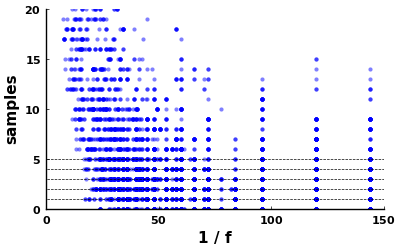

In [10]:
let d = 0.8
    subset = filter(r->r.d == d, tumorinfo)
    
    f = vcat( getproperty.( subset.mutations, :samples_freq)...)
    count = vcat( getproperty.( subset.mutations, :samplecount)...)
    scatter( 1 ./ f[.!iszero.(f)], count[.!iszero.(f)],
        ylim= (0, 20), xlim = (0, 150), grid=:off, legend=:none, size=(400,250),
        xlab="1 / f", ylab="samples", ms = 3, alpha = 0.5, c=:blue, markerstrokewidth=0
    )
    for n=1:5
       hline!([n], style=:dash, lw = 0.5, c=:black) 
    end
    hline!([samplingparams.n], c=:black)
end

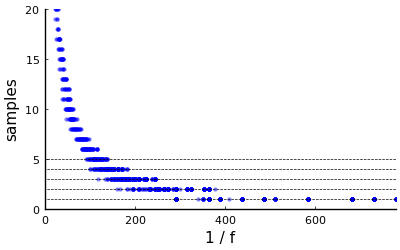

In [177]:
let d = 0.2
    subset = filter(r->r.d == d, tumorinfo)
    
    f = vcat( getproperty.( subset.mutations, :samples_freq)...)
    count = vcat( getproperty.( subset.mutations, :samplecount)...)
    scatter( 1 ./ f[.!iszero.(f)], count[.!iszero.(f)],
        ylim= (0, 20), xlim = (0, :auto), grid=:off, legend=:none, size=(400,250),
        xlab="1 / f", ylab="samples", ms = 3, alpha = 0.5, c=:blue, markerstrokewidth=0
    )
    for n=1:5
       hline!([n], style=:dash, lw = 0.5, c=:black) 
    end
    hline!([samplingparams.n], c=:black)
end

> use known N

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


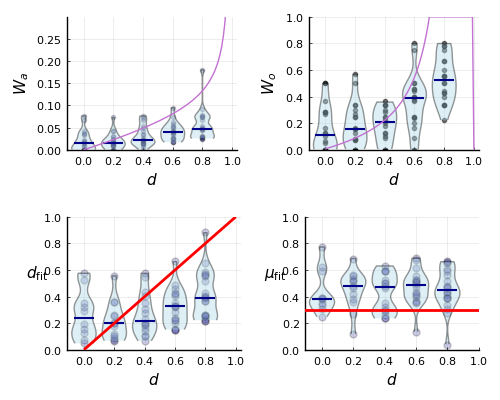

In [187]:
f_min = 1/100
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = true, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=1/f_min,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = 1/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


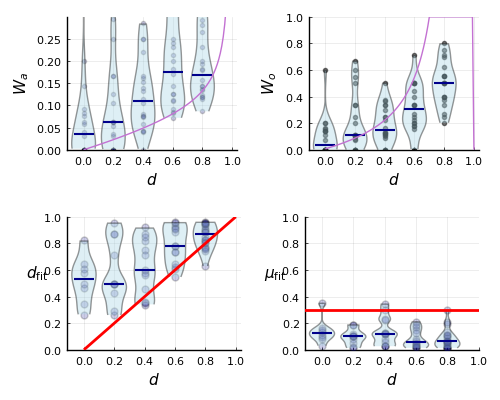

In [132]:
f_min = 1/100
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = true, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=1/f_min,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = 1/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


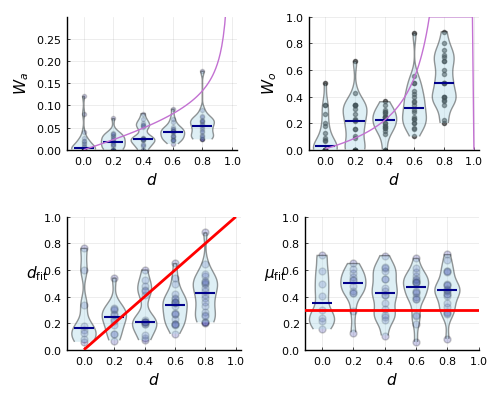

In [118]:
f_min = 1/100
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = true, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=1/f_min,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = 1/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


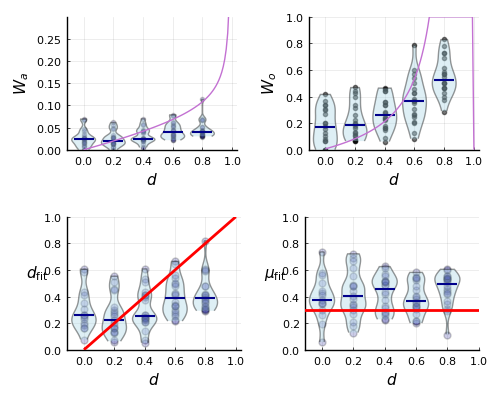

In [181]:
f_min = 1/200
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = true, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=1/f_min,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = 1/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


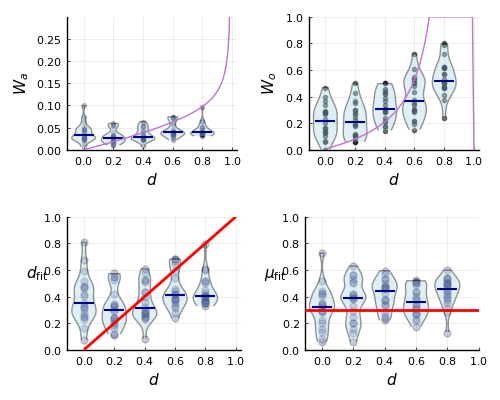

In [182]:
f_min = 1/300
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = true, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=1/f_min,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = 1/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

## use N estimate & f_min cutoff

### 23 deep + 285 shallow

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


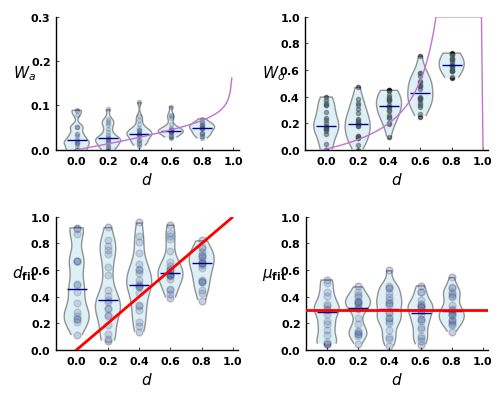

In [9]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200), grid=false,
    usecorrection=true, xlim=[-0.1, 1])
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200), xlim=[-0.1, 1], grid=false)

plot(p1,p2, layout = (2,1), size=(500,400))

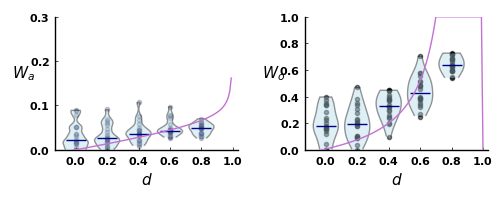

In [10]:
plot(p1[1])

In [201]:
name = "turnover_285shallow_23deep_3d_W"
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".pdf"))
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".png"))

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


#### poisson

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


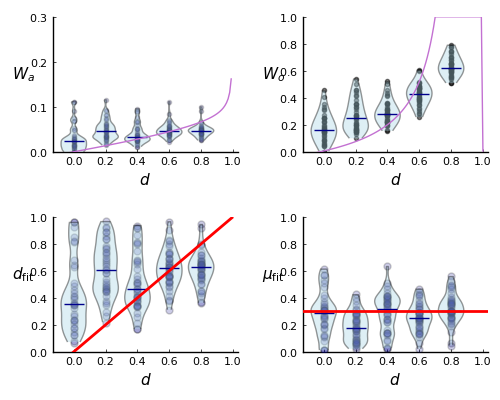

In [14]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200), grid=false,
    usecorrection=true, xlim=[-0.1, 1])
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200), xlim=[-0.1, 1], grid=false)

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


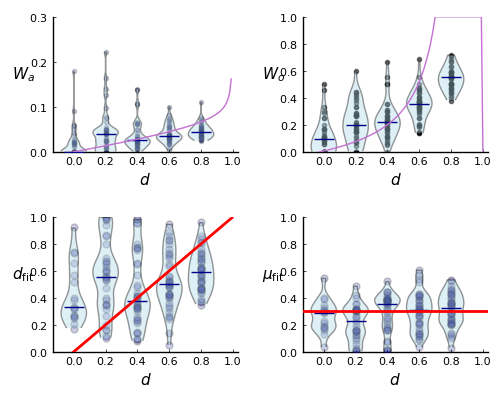

In [55]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200), grid=false,
    usecorrection=true, xlim=[-0.1, 1])
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200), xlim=[-0.1, 1], grid=false)

plot(p1,p2, layout = (2,1), size=(500,400))

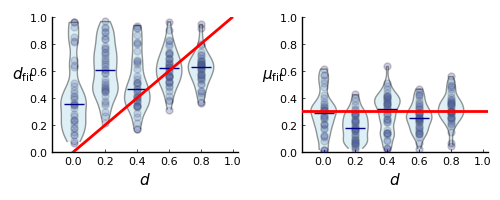

In [24]:
plot(p2[1])

In [25]:
name = "turnover_285shallow_23deep_3d_inference_poisson"
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".pdf"))
savefig(joinpath("Turnover\\turnover_plots\\inference", name*".png"))

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


### 120 deep + 285 shallow

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


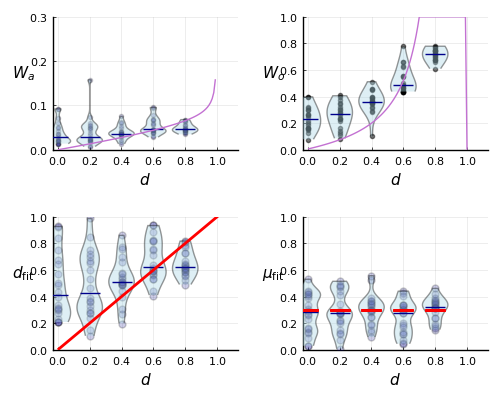

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [63]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200),
    usecorrection=true)
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


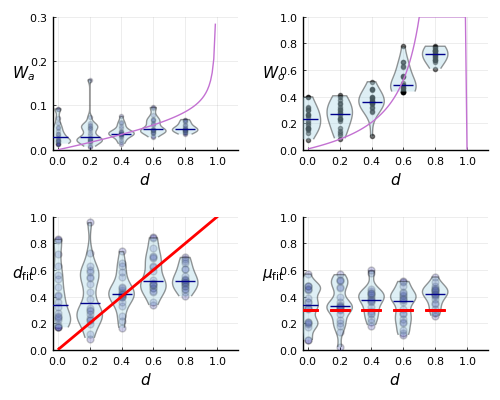

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [66]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200),
    usecorrection=true)
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

### 60 deep + 285 shallow

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


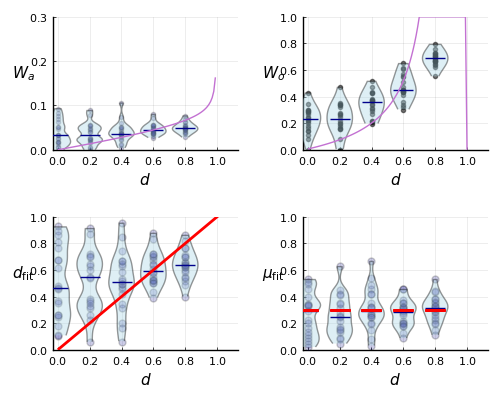

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [52]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200),
    usecorrection=true)
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


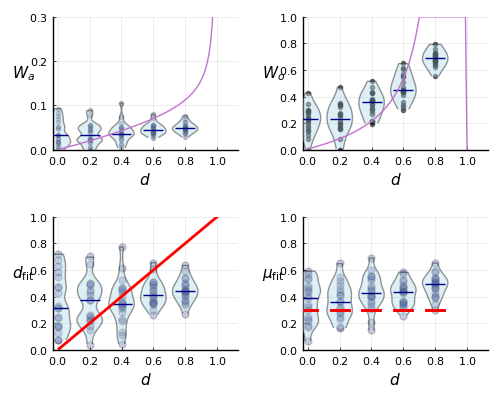

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [54]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200),
    usecorrection=true)
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

### 30 deep + 100 shallow

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


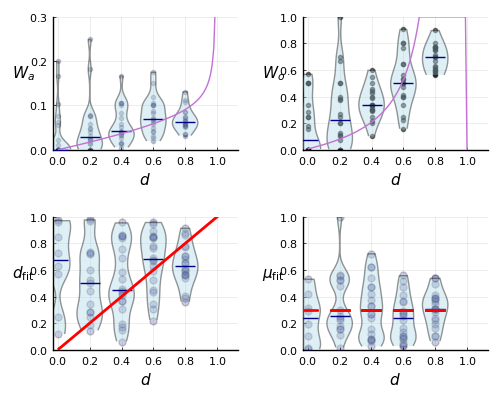

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [107]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200),
    usecorrection=true)
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


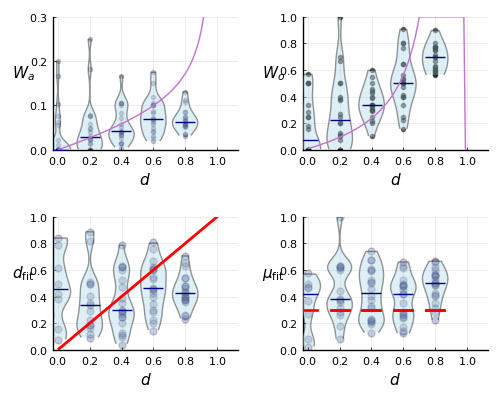

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [109]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200),
    usecorrection=true)
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

### 30 deep + 200 shallow

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


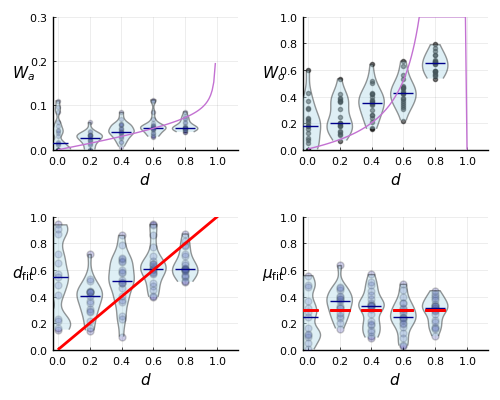

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [101]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200),
    usecorrection=true)
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


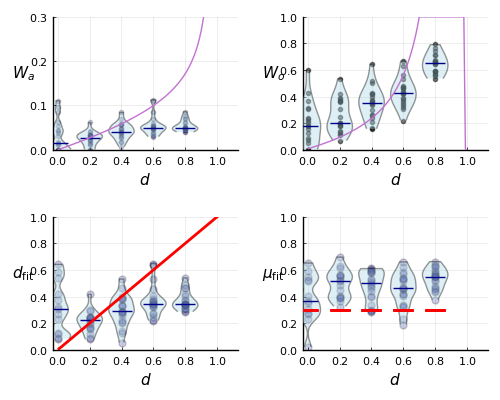

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [103]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200),
    usecorrection=true)
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

### 30 deep + 400 shallow

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


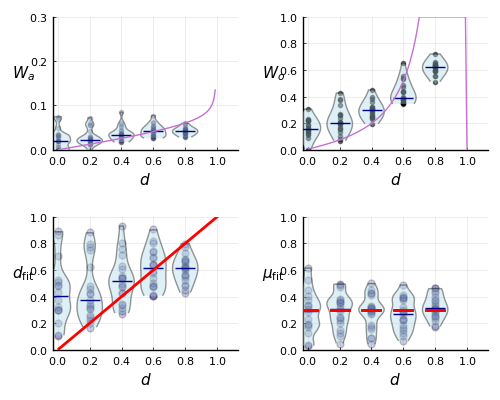

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [95]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200),
    usecorrection=true)
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


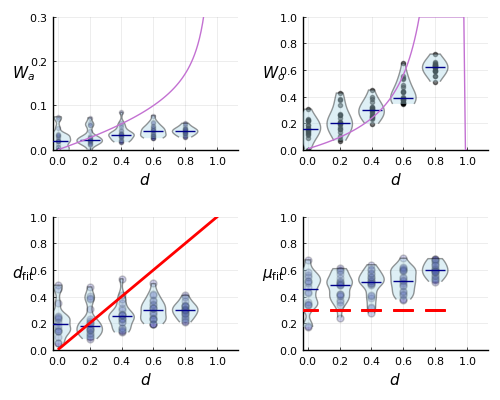

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [97]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200),
    usecorrection=true)
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

### 30 deep + 285 shallow

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


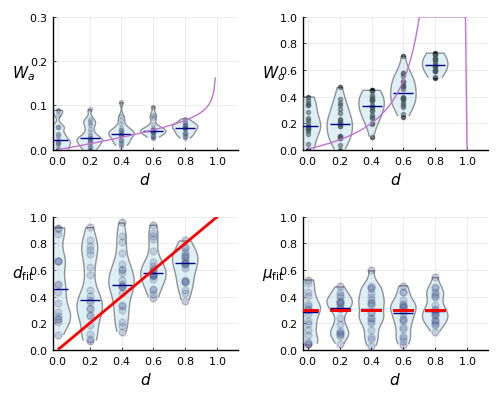

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [39]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200),
    usecorrection=true)
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


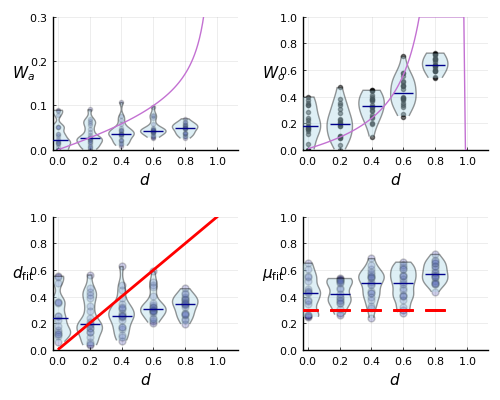

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [41]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200),
    usecorrection=true)
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

### 15 deep + 285 shallow

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


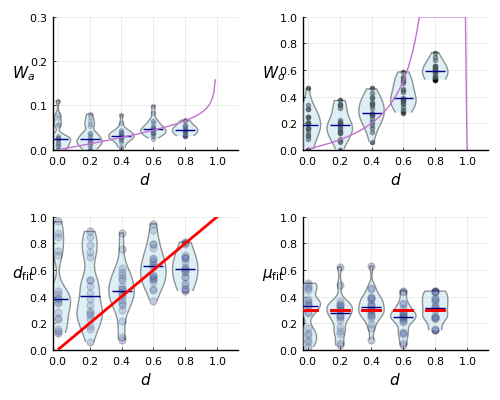

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [81]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200),
    usecorrection=true)
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


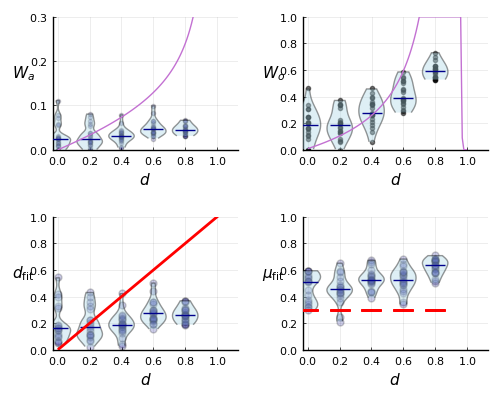

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [83]:
f_min = 2
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samplingtumor,
    sample_freq_col = :frequency,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N / f_min, yguidefontrotation=-90,
    mu=mu, size=(500,200),
    usecorrection=true)
plot!(p1[1],  yticks=0:0.1:0.3,)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

> f > 1/30, N = 4000

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


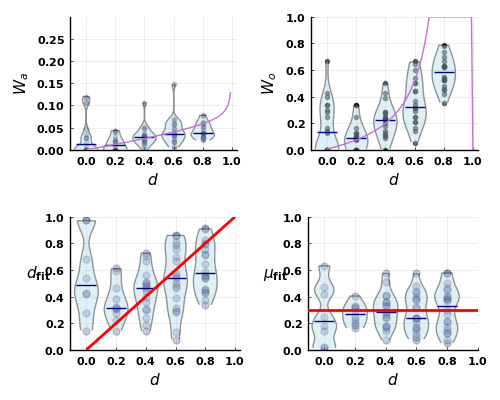

In [14]:
f_min = 1/30
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    sample_freq_col = :samples_freq,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = 4000)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

> f > 1/50, N = 4000

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


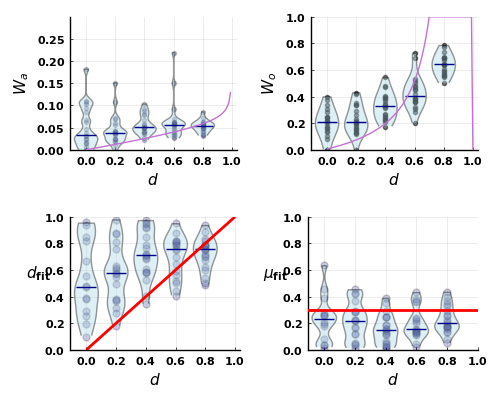

In [12]:
f_min = 1/50
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    sample_freq_col = :samples_freq,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = 4000)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

> f > 1/30, N = 100

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


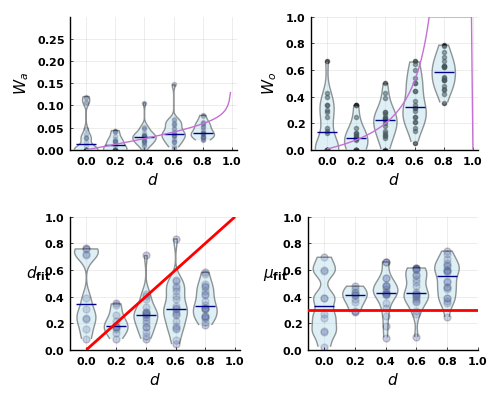

In [23]:
f_min = 1/30
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    sample_freq_col = :samples_freq,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = 100)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

> f > 1/100, N = 100

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


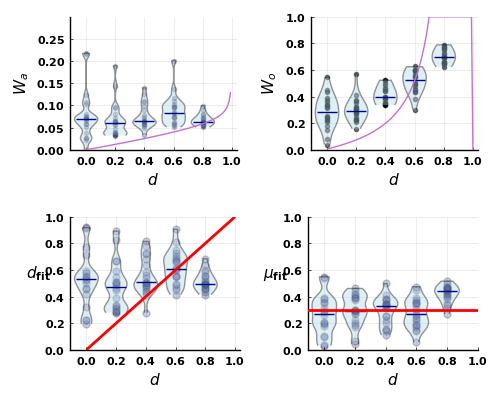

In [32]:
f_min = 1/100
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    sample_freq_col = :samples_freq,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = 100)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


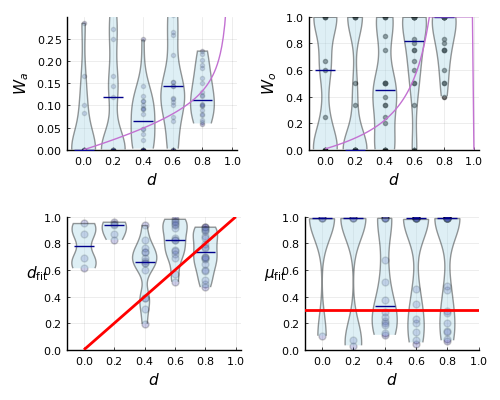

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [36]:
f_min = 1/20
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


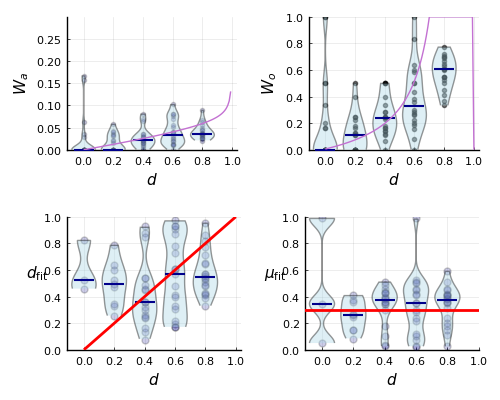

In [188]:
f_min = 1/50
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


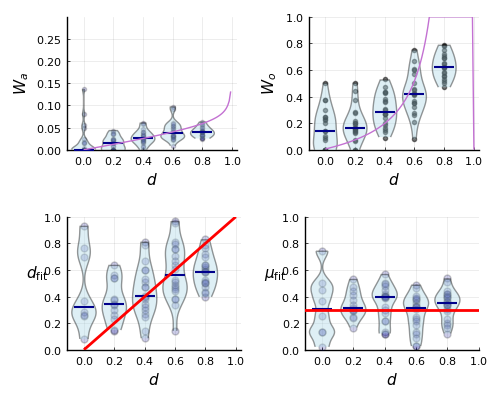

In [185]:
f_min = 1/100
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

In [ ]:
f_min = 1/100
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


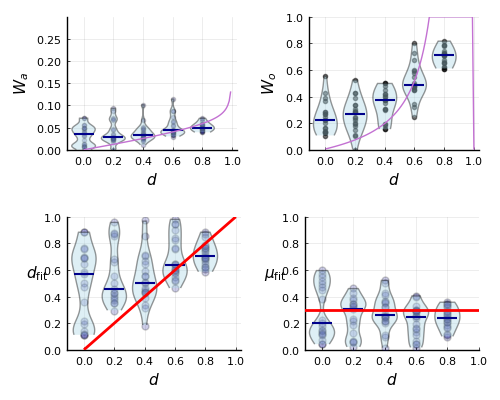

In [189]:
f_min = 1/200
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


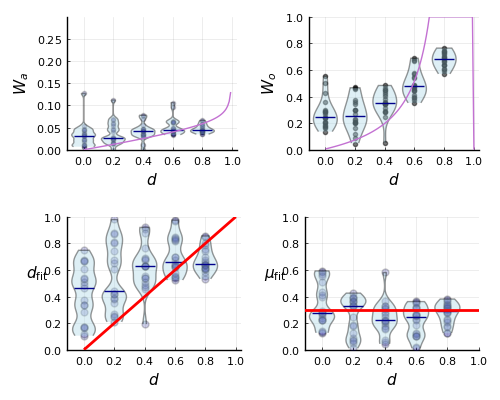

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [10]:
f_min = 1/200
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

In [12]:
name = "turnover_n280_3d_W"
savefig("Turnover\\turnover_plots\\inference\\"*name*".pdf")
savefig("Turnover\\turnover_plots\\inference\\"*name*".png")

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


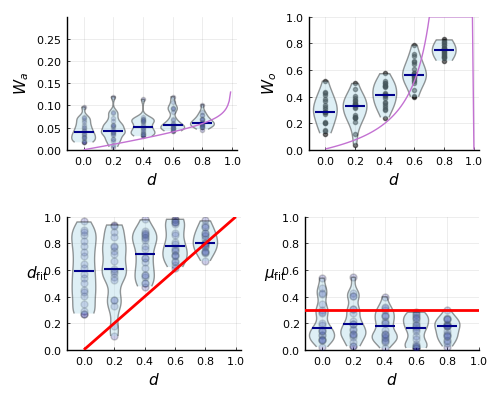

In [190]:
f_min = 1/300
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))